In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeCV, LassoCV, Ridge, Lasso
import lightgbm as lgb
from tqdm import tqdm
import pickle
import seaborn as sns
from sklearn.svm import SVC

%matplotlib inline

In [2]:
# Удалить отступ у строки заголовка
train = pd.read_csv('data/train.csv', sep='\t', index_col=0)
test = pd.read_csv('data/test.csv', sep='\t', index_col=0)
test = test.iloc[:, 1:]       # убираем 0 столбец таргет

seed = 42

In [3]:
# Разбиение на трейн и таргет
X = train.iloc[:,1:]
y = train.iloc[:,0]
# Разбиение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True, stratify=y)

### Отбор признаков - Логистическая регрессия

In [9]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
logit_grid = LogisticRegressionCV(Cs=[0.13], cv=cv, scoring = 'roc_auc', verbose=True, n_jobs=-1)
logit_grid.fit(X_train, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, logit_grid.predict_proba(X_train)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit_grid.predict_proba(X_val)[:,1]))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


roc_auc_train:  0.744054128375
roc_auc_val:  0.723399754653
Wall time: 4.19 s


In [4]:
%%time
logit = LogisticRegression(C=0.13, n_jobs=-1, random_state=seed)
logit.fit(X_train, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, logit.predict_proba(X_train)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit.predict_proba(X_val)[:,1]))

D:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


roc_auc_train:  0.743811416053
roc_auc_val:  0.722948206073
Wall time: 1.27 s


In [7]:
roc_auc_345 = roc_auc_score(y_val, logit.predict_proba(X_val)[:,1])
roc_auc_345

0.72294820607302512

In [39]:
def feature_selection(model):
    feature_score = {}
    for i in tqdm(range(X_train.shape[1])):
        X_train1 = X_train.drop(str(i+1), axis=1)
        X_val1 = X_val.drop(str(i+1), axis=1)
        model.fit(X_train1, y_train)
        feature_score[i+1] = roc_auc_score(y_val, logit.predict_proba(X_val1)[:,1])
    return feature_score

In [49]:
def feature_selection(model):
    
    X_train_f = X_train
    X_val_f = X_val
    #X_train_f = X_train.iloc[:, :10]
    #X_val_f = X_val.iloc[:, :10]
    count = 1
    drop_features = []
    max_score = roc_auc_345
    #max_score = 0
    
    #while True
    for f in range(344):
    
        feature_score = {}

        # выкидываем 1 признак, считаем скор
        for i in tqdm(X_train_f.columns):
            X_train1 = X_train_f.drop(i, axis=1)
            X_val1 = X_val_f.drop(i, axis=1)
            model.fit(X_train1, y_train)
            feature_score[i] = roc_auc_score(y_val, logit.predict_proba(X_val1)[:,1])

        # находим признак, выкидывание которого дает максимальный скор
        feature = max(feature_score, key=feature_score.get)
        score = feature_score[feature]
        
        # если максимальный скор меньше, то на выход
        if score <= max_score:
            print('Complete!')
            break
            
        drop_features.append(feature)
        max_score = score
        
        # убираем этот признак
        X_train_f = X_train_f.drop(feature, axis=1)
        X_val_f = X_val_f.drop(feature, axis=1)

        print('Stage {}, drop_feature {}, roc_auc_score {}'.format(count, feature, score))

        count += 1
        
    return drop_features

In [50]:
logit = LogisticRegression(C=0.13, random_state=seed)
drop_features = feature_selection(logit)

100%|████████████████████████████████████████████████████████████████████████████████| 344/344 [05:19<00:00,  1.08it/s]


Stage 1, drop_feature 54, roc_auc_score 0.7234574617162337


100%|████████████████████████████████████████████████████████████████████████████████| 343/343 [05:20<00:00,  1.07it/s]


Stage 2, drop_feature 83, roc_auc_score 0.723968738944457


100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [05:10<00:00,  1.10it/s]


Stage 3, drop_feature 345, roc_auc_score 0.7244728487349013


100%|████████████████████████████████████████████████████████████████████████████████| 341/341 [05:13<00:00,  1.09it/s]


Stage 4, drop_feature 75, roc_auc_score 0.724930645850467


100%|████████████████████████████████████████████████████████████████████████████████| 340/340 [05:12<00:00,  1.09it/s]


Stage 5, drop_feature 49, roc_auc_score 0.725524072942463


100%|████████████████████████████████████████████████████████████████████████████████| 339/339 [05:04<00:00,  1.11it/s]


Stage 6, drop_feature 52, roc_auc_score 0.7259388654313557


100%|████████████████████████████████████████████████████████████████████████████████| 338/338 [05:04<00:00,  1.11it/s]


Stage 7, drop_feature 86, roc_auc_score 0.7263452040192786


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [05:11<00:00,  1.08it/s]


Stage 8, drop_feature 67, roc_auc_score 0.7268680594162213


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [05:11<00:00,  1.08it/s]


Stage 9, drop_feature 203, roc_auc_score 0.7272440742289261


100%|████████████████████████████████████████████████████████████████████████████████| 335/335 [05:05<00:00,  1.10it/s]


Stage 10, drop_feature 190, roc_auc_score 0.7275870085595746


100%|████████████████████████████████████████████████████████████████████████████████| 334/334 [05:04<00:00,  1.10it/s]


Stage 11, drop_feature 245, roc_auc_score 0.727899986675917


100%|████████████████████████████████████████████████████████████████████████████████| 333/333 [05:04<00:00,  1.09it/s]


Stage 12, drop_feature 295, roc_auc_score 0.7281907273570991


100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [05:38<00:00,  1.02s/it]


Stage 13, drop_feature 271, roc_auc_score 0.7286788482478831


100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [05:37<00:00,  1.02s/it]


Stage 14, drop_feature 88, roc_auc_score 0.7289670160026832


100%|████████████████████████████████████████████████████████████████████████████████| 330/330 [05:13<00:00,  1.05it/s]


Stage 15, drop_feature 136, roc_auc_score 0.7292386435164552


100%|████████████████████████████████████████████████████████████████████████████████| 329/329 [05:13<00:00,  1.05it/s]


Stage 16, drop_feature 337, roc_auc_score 0.7294674501840102


100%|████████████████████████████████████████████████████████████████████████████████| 328/328 [06:07<00:00,  1.12s/it]


Stage 17, drop_feature 108, roc_auc_score 0.7297177591649016


100%|████████████████████████████████████████████████████████████████████████████████| 327/327 [06:16<00:00,  1.15s/it]


Stage 18, drop_feature 231, roc_auc_score 0.7299610844884701


100%|████████████████████████████████████████████████████████████████████████████████| 326/326 [06:21<00:00,  1.17s/it]


Stage 19, drop_feature 292, roc_auc_score 0.7302055124947737


100%|████████████████████████████████████████████████████████████████████████████████| 325/325 [05:58<00:00,  1.10s/it]


Stage 20, drop_feature 74, roc_auc_score 0.7304102439226101


100%|████████████████████████████████████████████████████████████████████████████████| 324/324 [05:28<00:00,  1.01s/it]


Stage 21, drop_feature 225, roc_auc_score 0.7306269210800778


100%|████████████████████████████████████████████████████████████████████████████████| 323/323 [05:26<00:00,  1.01s/it]


Stage 22, drop_feature 40, roc_auc_score 0.7308434144570896


100%|████████████████████████████████████████████████████████████████████████████████| 322/322 [05:20<00:00,  1.00it/s]


Stage 23, drop_feature 184, roc_auc_score 0.7310532917376902


100%|████████████████████████████████████████████████████████████████████████████████| 321/321 [05:19<00:00,  1.01it/s]


Stage 24, drop_feature 32, roc_auc_score 0.7312631690182907


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [05:18<00:00,  1.00it/s]


Stage 25, drop_feature 66, roc_auc_score 0.7314452954500553


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [05:16<00:00,  1.01it/s]


Stage 26, drop_feature 72, roc_auc_score 0.7316590321202292


100%|████████████████████████████████████████████████████████████████████████████████| 318/318 [05:10<00:00,  1.03it/s]


Stage 27, drop_feature 95, roc_auc_score 0.7318661526939918


100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [05:15<00:00,  1.00it/s]


Stage 28, drop_feature 36, roc_auc_score 0.7320813596078125


100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [05:01<00:00,  1.05it/s]


Stage 29, drop_feature 266, roc_auc_score 0.7322605455522834


100%|████████████████████████████████████████████████████████████████████████████████| 315/315 [04:57<00:00,  1.06it/s]


Stage 30, drop_feature 315, roc_auc_score 0.7324487367390914


100%|████████████████████████████████████████████████████████████████████████████████| 314/314 [05:12<00:00,  1.00it/s]


Stage 31, drop_feature 98, roc_auc_score 0.7326214903676068


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [05:14<00:00,  1.01s/it]


Stage 32, drop_feature 29, roc_auc_score 0.7328128058221648


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [05:05<00:00,  1.02it/s]


Stage 33, drop_feature 81, roc_auc_score 0.7330144129822515


100%|████████████████████████████████████████████████████████████████████████████████| 311/311 [05:00<00:00,  1.03it/s]


Stage 34, drop_feature 168, roc_auc_score 0.7331877179521343


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [04:56<00:00,  1.04it/s]


Stage 35, drop_feature 142, roc_auc_score 0.7334791937551401


100%|████████████████████████████████████████████████████████████████████████████████| 309/309 [04:52<00:00,  1.06it/s]


Stage 36, drop_feature 34, roc_auc_score 0.7337868422382621


100%|████████████████████████████████████████████████████████████████████████████████| 308/308 [04:16<00:00,  1.20it/s]


Stage 37, drop_feature 91, roc_auc_score 0.7339678659872915


100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [04:15<00:00,  1.20it/s]


Stage 38, drop_feature 96, roc_auc_score 0.7341080904751185


100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [04:15<00:00,  1.20it/s]


Stage 39, drop_feature 159, roc_auc_score 0.7342367367942256


100%|████████████████████████████████████████████████████████████████████████████████| 305/305 [04:14<00:00,  1.20it/s]


Stage 40, drop_feature 286, roc_auc_score 0.7343705289660971


100%|████████████████████████████████████████████████████████████████████████████████| 304/304 [04:14<00:00,  1.20it/s]


Stage 41, drop_feature 208, roc_auc_score 0.73450781296663


100%|████████████████████████████████████████████████████████████████████████████████| 303/303 [04:09<00:00,  1.21it/s]


Stage 42, drop_feature 37, roc_auc_score 0.7346114651437392


100%|████████████████████████████████████████████████████████████████████████████████| 302/302 [04:18<00:00,  1.17it/s]


Stage 43, drop_feature 189, roc_auc_score 0.7347075823221578


100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [04:07<00:00,  1.22it/s]


Stage 44, drop_feature 14, roc_auc_score 0.7348411907135737


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:15<00:00,  1.18it/s]


Stage 45, drop_feature 176, roc_auc_score 0.7349371241115363


100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [04:10<00:00,  1.19it/s]


Stage 46, drop_feature 87, roc_auc_score 0.7350705487224961


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [04:23<00:00,  1.13it/s]


Stage 47, drop_feature 243, roc_auc_score 0.7351688712663851


100%|████████████████████████████████████████████████████████████████████████████████| 297/297 [04:19<00:00,  1.14it/s]


Stage 48, drop_feature 272, roc_auc_score 0.735260577713863


100%|████████████████████████████████████████████████████████████████████████████████| 296/296 [04:18<00:00,  1.15it/s]


Stage 49, drop_feature 280, roc_auc_score 0.735345116723562


100%|████████████████████████████████████████████████████████████████████████████████| 295/295 [04:15<00:00,  1.16it/s]


Stage 50, drop_feature 281, roc_auc_score 0.735431125976908


100%|████████████████████████████████████████████████████████████████████████████████| 294/294 [04:15<00:00,  1.15it/s]


Stage 51, drop_feature 318, roc_auc_score 0.7355397402263256


100%|████████████████████████████████████████████████████████████████████████████████| 293/293 [04:15<00:00,  1.15it/s]


Stage 52, drop_feature 262, roc_auc_score 0.7356801484946083


100%|████████████████████████████████████████████████████████████████████████████████| 292/292 [04:10<00:00,  1.17it/s]


Stage 53, drop_feature 331, roc_auc_score 0.7357828817694382


100%|████████████████████████████████████████████████████████████████████████████████| 291/291 [04:00<00:00,  1.21it/s]


Stage 54, drop_feature 33, roc_auc_score 0.7358775287042099


100%|████████████████████████████████████████████████████████████████████████████████| 290/290 [03:59<00:00,  1.21it/s]


Stage 55, drop_feature 56, roc_auc_score 0.735970337834423


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [03:57<00:00,  1.22it/s]


Stage 56, drop_feature 82, roc_auc_score 0.7360699468415031


100%|████████████████████████████████████████████████████████████████████████████████| 288/288 [04:04<00:00,  1.18it/s]


Stage 57, drop_feature 158, roc_auc_score 0.7361658802394659


100%|████████████████████████████████████████████████████████████████████████████████| 287/287 [04:08<00:00,  1.15it/s]


Stage 58, drop_feature 311, roc_auc_score 0.7362482138836945


100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [03:56<00:00,  1.21it/s]


Stage 59, drop_feature 84, roc_auc_score 0.7363391852093488


100%|████████████████████████████████████████████████████████████████████████████████| 285/285 [03:48<00:00,  1.25it/s]


Stage 60, drop_feature 17, roc_auc_score 0.736408286660755


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [03:47<00:00,  1.25it/s]


Stage 61, drop_feature 153, roc_auc_score 0.7365411599303471


100%|████████████████████████████████████████████████████████████████████████████████| 283/283 [03:46<00:00,  1.25it/s]


Stage 62, drop_feature 133, roc_auc_score 0.7366187152827233


100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [03:45<00:00,  1.25it/s]


Stage 63, drop_feature 129, roc_auc_score 0.7366896545386881


100%|████████████████████████████████████████████████████████████████████████████████| 281/281 [03:43<00:00,  1.26it/s]


Stage 64, drop_feature 9, roc_auc_score 0.7367556317223445


100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [03:42<00:00,  1.26it/s]


Stage 65, drop_feature 2, roc_auc_score 0.7369024723065825


100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [03:44<00:00,  1.24it/s]


Stage 66, drop_feature 8, roc_auc_score 0.7369910544863106


100%|████████████████████████████████████████████████████████████████████████████████| 278/278 [03:44<00:00,  1.24it/s]


Stage 67, drop_feature 112, roc_auc_score 0.7370524371585703


100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [03:37<00:00,  1.27it/s]


Stage 68, drop_feature 80, roc_auc_score 0.7371428571428571


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:37<00:00,  1.27it/s]


Stage 69, drop_feature 78, roc_auc_score 0.7372296015180265


100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [03:37<00:00,  1.26it/s]


Stage 70, drop_feature 68, roc_auc_score 0.7372970489453299


100%|████████████████████████████████████████████████████████████████████████████████| 274/274 [03:34<00:00,  1.28it/s]


Stage 71, drop_feature 237, roc_auc_score 0.737352366862546


100%|████████████████████████████████████████████████████████████████████████████████| 273/273 [03:24<00:00,  1.34it/s]


Stage 72, drop_feature 1, roc_auc_score 0.737403641609733


100%|████████████████████████████████████████████████████████████████████████████████| 272/272 [03:30<00:00,  1.29it/s]


Stage 73, drop_feature 53, roc_auc_score 0.7374705376956687


100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [03:29<00:00,  1.29it/s]


Stage 74, drop_feature 22, roc_auc_score 0.7375355959770458


100%|████████████████████████████████████████████████████████████████████████████████| 270/270 [03:26<00:00,  1.31it/s]


Stage 75, drop_feature 330, roc_auc_score 0.7376001029170554


100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [03:22<00:00,  1.33it/s]


Stage 76, drop_feature 101, roc_auc_score 0.737657442419286


100%|████████████████████████████████████████████████████████████████████████████████| 268/268 [03:22<00:00,  1.32it/s]


Stage 77, drop_feature 114, roc_auc_score 0.7377199277742809


100%|████████████████████████████████████████████████████████████████████████████████| 267/267 [03:19<00:00,  1.34it/s]


Stage 78, drop_feature 7, roc_auc_score 0.7377827806901875


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [03:17<00:00,  1.35it/s]


Stage 79, drop_feature 282, roc_auc_score 0.7378325851937276


100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [03:16<00:00,  1.35it/s]


Stage 80, drop_feature 307, roc_auc_score 0.7378919462809727


100%|████████████████████████████████████████████████████████████████████████████████| 264/264 [03:17<00:00,  1.34it/s]


Stage 81, drop_feature 306, roc_auc_score 0.7379321942008077


100%|████████████████████████████████████████████████████████████████████████████████| 263/263 [03:14<00:00,  1.35it/s]


Stage 82, drop_feature 202, roc_auc_score 0.7379757501688483


100%|████████████████████████████████████████████████████████████████████████████████| 262/262 [03:13<00:00,  1.36it/s]


Stage 83, drop_feature 288, roc_auc_score 0.7380209601609916


100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [03:12<00:00,  1.36it/s]


Stage 84, drop_feature 264, roc_auc_score 0.7380628621049294


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [03:11<00:00,  1.36it/s]


Stage 85, drop_feature 229, roc_auc_score 0.7380909805146771


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [03:10<00:00,  1.36it/s]


Stage 86, drop_feature 122, roc_auc_score 0.7381268177035714


100%|████████████████████████████████████████████████████████████████████████████████| 258/258 [03:11<00:00,  1.35it/s]


Stage 87, drop_feature 299, roc_auc_score 0.7381727628175381


100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [03:10<00:00,  1.35it/s]


Stage 88, drop_feature 111, roc_auc_score 0.7382242213451811


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [03:08<00:00,  1.36it/s]


Stage 89, drop_feature 248, roc_auc_score 0.7382677773132216


100%|████████████████████████████████████████████████████████████████████████████████| 255/255 [03:08<00:00,  1.35it/s]


Stage 90, drop_feature 283, roc_auc_score 0.7383262194981874


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [03:06<00:00,  1.36it/s]


Stage 91, drop_feature 335, roc_auc_score 0.738419763750224


100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [02:58<00:00,  1.42it/s]


Stage 92, drop_feature 298, roc_auc_score 0.7384776545938223


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [02:55<00:00,  1.44it/s]


Stage 93, drop_feature 329, roc_auc_score 0.7385474911670519


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [02:51<00:00,  1.47it/s]


Stage 94, drop_feature 99, roc_auc_score 0.7386121818875171


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [02:55<00:00,  1.43it/s]


Stage 95, drop_feature 239, roc_auc_score 0.7386702565115714


100%|████████████████████████████████████████████████████████████████████████████████| 249/249 [02:52<00:00,  1.45it/s]


Stage 96, drop_feature 323, roc_auc_score 0.7387285149160813


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [02:47<00:00,  1.48it/s]


Stage 97, drop_feature 92, roc_auc_score 0.7387715195427542


100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [02:46<00:00,  1.49it/s]


Stage 98, drop_feature 19, roc_auc_score 0.7388200375831031


100%|████████████████████████████████████████████████████████████████████████████████| 246/246 [02:45<00:00,  1.49it/s]


Stage 99, drop_feature 314, roc_auc_score 0.7388665340384376


100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [02:41<00:00,  1.52it/s]


Stage 100, drop_feature 55, roc_auc_score 0.7389236897602123


100%|████████████████████████████████████████████████████████████████████████████████| 244/244 [02:42<00:00,  1.50it/s]


Stage 101, drop_feature 154, roc_auc_score 0.7389643052409591


100%|████████████████████████████████████████████████████████████████████████████████| 243/243 [02:39<00:00,  1.52it/s]


Stage 102, drop_feature 24, roc_auc_score 0.738997753283927


100%|████████████████████████████████████████████████████████████████████████████████| 242/242 [02:39<00:00,  1.52it/s]


Stage 103, drop_feature 252, roc_auc_score 0.7390438821783498


100%|████████████████████████████████████████████████████████████████████████████████| 241/241 [02:38<00:00,  1.52it/s]


Stage 104, drop_feature 293, roc_auc_score 0.7390657520525981


100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [02:37<00:00,  1.52it/s]


Stage 105, drop_feature 6, roc_auc_score 0.7390839463177288


100%|████████████████████████████████████████████████████████████████████████████████| 239/239 [02:36<00:00,  1.53it/s]


Stage 106, drop_feature 267, roc_auc_score 0.7391047135092419


100%|████████████████████████████████████████████████████████████████████████████████| 238/238 [02:36<00:00,  1.52it/s]


Stage 107, drop_feature 220, roc_auc_score 0.7391260320421225


100%|████████████████████████████████████████████████████████████████████████████████| 237/237 [02:35<00:00,  1.53it/s]


Stage 108, drop_feature 291, roc_auc_score 0.7391513937450321


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [02:34<00:00,  1.53it/s]


Stage 109, drop_feature 93, roc_auc_score 0.7391684853274277


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:32<00:00,  1.54it/s]


Stage 110, drop_feature 198, roc_auc_score 0.7391905389821318


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [02:30<00:00,  1.56it/s]


Stage 111, drop_feature 187, roc_auc_score 0.7392105710518214


100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [02:29<00:00,  1.56it/s]


Stage 112, drop_feature 310, roc_auc_score 0.7392375867788339


100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [02:31<00:00,  1.54it/s]


Stage 113, drop_feature 177, roc_auc_score 0.7392508189716563


100%|████████████████████████████████████████████████████████████████████████████████| 231/231 [02:28<00:00,  1.56it/s]


Stage 114, drop_feature 58, roc_auc_score 0.7392813265273305


100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [02:27<00:00,  1.56it/s]


Stage 115, drop_feature 143, roc_auc_score 0.7393144070093867


100%|████████████████████████████████████████████████████████████████████████████████| 229/229 [02:26<00:00,  1.56it/s]


Stage 116, drop_feature 109, roc_auc_score 0.7393430767605018


100%|████████████████████████████████████████████████████████████████████████████████| 228/228 [02:24<00:00,  1.58it/s]


Stage 117, drop_feature 166, roc_auc_score 0.7393563089533244


100%|████████████████████████████████████████████████████████████████████████████████| 227/227 [02:24<00:00,  1.57it/s]


Stage 118, drop_feature 23, roc_auc_score 0.7393908596790275


100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [02:23<00:00,  1.57it/s]


Stage 119, drop_feature 200, roc_auc_score 0.7394064810177761


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [02:22<00:00,  1.58it/s]


Stage 120, drop_feature 195, roc_auc_score 0.7394358858907149


100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [02:14<00:00,  1.67it/s]


Stage 121, drop_feature 196, roc_auc_score 0.7394704366164181


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [02:12<00:00,  1.69it/s]


Stage 122, drop_feature 343, roc_auc_score 0.739494144295225


100%|████████████████████████████████████████████████████████████████████████████████| 222/222 [02:19<00:00,  1.59it/s]


Stage 123, drop_feature 336, roc_auc_score 0.7395154628281055


100%|████████████████████████████████████████████████████████████████████████████████| 221/221 [02:18<00:00,  1.60it/s]


Stage 124, drop_feature 247, roc_auc_score 0.7395220789245168


100%|████████████████████████████████████████████████████████████████████████████████| 220/220 [02:17<00:00,  1.59it/s]


Stage 125, drop_feature 230, roc_auc_score 0.739527408557737


100%|████████████████████████████████████████████████████████████████████████████████| 219/219 [02:18<00:00,  1.58it/s]


Stage 126, drop_feature 149, roc_auc_score 0.739535862458707


100%|████████████████████████████████████████████████████████████████████████████████| 218/218 [02:16<00:00,  1.60it/s]


Stage 127, drop_feature 322, roc_auc_score 0.7395428461160298


100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [02:17<00:00,  1.58it/s]


Stage 128, drop_feature 71, roc_auc_score 0.7395698618430424


100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [02:15<00:00,  1.59it/s]


Stage 129, drop_feature 313, roc_auc_score 0.7395825426944971


100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [02:14<00:00,  1.60it/s]


Stage 130, drop_feature 85, roc_auc_score 0.7395998180573488


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:13<00:00,  1.60it/s]


Stage 131, drop_feature 59, roc_auc_score 0.7397304859614704


100%|████████████████████████████████████████████████████████████████████████████████| 213/213 [02:12<00:00,  1.61it/s]


Stage 132, drop_feature 94, roc_auc_score 0.7397694474181143


100%|████████████████████████████████████████████████████████████████████████████████| 212/212 [02:09<00:00,  1.64it/s]


Stage 133, drop_feature 320, roc_auc_score 0.7398141060688901


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [02:05<00:00,  1.68it/s]


Stage 134, drop_feature 43, roc_auc_score 0.7398346894799472


100%|████████████████████████████████████████████████████████████████████████████████| 210/210 [02:05<00:00,  1.68it/s]


Stage 135, drop_feature 69, roc_auc_score 0.7398920289821778


100%|████████████████████████████████████████████████████████████████████████████████| 209/209 [02:04<00:00,  1.68it/s]


Stage 136, drop_feature 157, roc_auc_score 0.7399087530036618


100%|████████████████████████████████████████████████████████████████████████████████| 208/208 [02:03<00:00,  1.68it/s]


Stage 137, drop_feature 226, roc_auc_score 0.7399166555632641


100%|████████████████████████████████████████████████████████████████████████████████| 207/207 [02:03<00:00,  1.68it/s]


Stage 138, drop_feature 222, roc_auc_score 0.7399249256837781


100%|████████████████████████████████████████████████████████████████████████████████| 206/206 [02:04<00:00,  1.65it/s]


Stage 139, drop_feature 73, roc_auc_score 0.7399512062889673


100%|████████████████████████████████████████████████████████████████████████████████| 205/205 [02:04<00:00,  1.64it/s]


Stage 140, drop_feature 269, roc_auc_score 0.7399596601899371


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [02:03<00:00,  1.65it/s]


Stage 141, drop_feature 106, roc_auc_score 0.7399633357990544


100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [02:01<00:00,  1.68it/s]


Stage 142, drop_feature 104, roc_auc_score 0.7399739950654949


100%|████████████████████████████████████████████████████████████████████████████████| 202/202 [01:57<00:00,  1.71it/s]


Stage 143, drop_feature 340, roc_auc_score 0.7399796922596267


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [01:57<00:00,  1.72it/s]


Stage 144, drop_feature 170, roc_auc_score 0.739984838112391


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:56<00:00,  1.72it/s]


Stage 145, drop_feature 300, roc_auc_score 0.739987411038773


100%|████████████████████████████████████████████████████████████████████████████████| 199/199 [01:56<00:00,  1.71it/s]


Stage 146, drop_feature 135, roc_auc_score 0.7399896164042434


100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [01:55<00:00,  1.71it/s]


Stage 147, drop_feature 194, roc_auc_score 0.7399921893306256


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [01:53<00:00,  1.73it/s]


Stage 148, drop_feature 180, roc_auc_score 0.7399960487201988


100%|████████████████████████████████████████████████████████████████████████████████| 196/196 [01:53<00:00,  1.73it/s]


Stage 149, drop_feature 192, roc_auc_score 0.7399966000615664


100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [01:52<00:00,  1.74it/s]


Stage 150, drop_feature 232, roc_auc_score 0.739997151402934


100%|████████████████████████████████████████████████████████████████████████████████| 194/194 [01:51<00:00,  1.74it/s]


Stage 151, drop_feature 305, roc_auc_score 0.7399978865247575


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [01:50<00:00,  1.74it/s]


Stage 152, drop_feature 191, roc_auc_score 0.7399984378661251


100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [01:50<00:00,  1.74it/s]


Complete!


In [51]:
drop_features

['54',
 '83',
 '345',
 '75',
 '49',
 '52',
 '86',
 '67',
 '203',
 '190',
 '245',
 '295',
 '271',
 '88',
 '136',
 '337',
 '108',
 '231',
 '292',
 '74',
 '225',
 '40',
 '184',
 '32',
 '66',
 '72',
 '95',
 '36',
 '266',
 '315',
 '98',
 '29',
 '81',
 '168',
 '142',
 '34',
 '91',
 '96',
 '159',
 '286',
 '208',
 '37',
 '189',
 '14',
 '176',
 '87',
 '243',
 '272',
 '280',
 '281',
 '318',
 '262',
 '331',
 '33',
 '56',
 '82',
 '158',
 '311',
 '84',
 '17',
 '153',
 '133',
 '129',
 '9',
 '2',
 '8',
 '112',
 '80',
 '78',
 '68',
 '237',
 '1',
 '53',
 '22',
 '330',
 '101',
 '114',
 '7',
 '282',
 '307',
 '306',
 '202',
 '288',
 '264',
 '229',
 '122',
 '299',
 '111',
 '248',
 '283',
 '335',
 '298',
 '329',
 '99',
 '239',
 '323',
 '92',
 '19',
 '314',
 '55',
 '154',
 '24',
 '252',
 '293',
 '6',
 '267',
 '220',
 '291',
 '93',
 '198',
 '187',
 '310',
 '177',
 '58',
 '143',
 '109',
 '166',
 '23',
 '200',
 '195',
 '196',
 '343',
 '336',
 '247',
 '230',
 '149',
 '322',
 '71',
 '313',
 '85',
 '59',
 '94',
 '

In [82]:
len(drop_features)

152

In [53]:
with open('drop_features.pkl', 'wb') as file:
    pickle.dump(drop_features, file)

In [72]:
len(X_train.columns)

345

In [86]:
# дропнутые фичи
X_train_df = X_train.drop(drop_features, axis=1)
X_val_df = X_val.drop(drop_features, axis=1)

In [85]:
X_train_df.head()

,3,4,5,10,11,12,13,15,16,18,...,327,328,332,333,334,338,339,341,342,344
29430,0,0,0,1,1,1,0.000000,0,0,0,...,0.718874,0.327404,0,0.157038,0.691249,1,0,0.000000,1,1
29132,0,0,0,1,1,1,0.666667,0,0,0,...,0.735186,0.297473,0,0.177254,0.711283,1,0,0.444444,1,1
14578,0,0,0,1,1,1,0.071429,0,0,0,...,0.848982,0.000000,1,0.430418,0.858922,0,0,0.000000,1,1
17872,0,0,0,1,1,1,0.000000,0,0,0,...,1.000000,0.017365,1,1.000000,1.000000,0,0,0.000000,1,1
20144,0,1,0,1,1,1,0.181818,0,0,0,...,0.735186,0.297473,0,0.177254,0.711283,1,0,0.444444,1,1


In [87]:
# скор на холдауте
logit = LogisticRegression(C=0.13, random_state=seed)
logit.fit(X_train_df, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, logit.predict_proba(X_train_df)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit.predict_proba(X_val_df)[:,1]))

roc_auc_train:  0.731709122191
roc_auc_val:  0.739995129818


In [88]:
# скор на cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
logit_grid = LogisticRegressionCV(Cs=[0.13], cv=cv, scoring = 'roc_auc', verbose=True, n_jobs=-1)
logit_grid.fit(X_train_df, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, logit_grid.predict_proba(X_train_df)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit_grid.predict_proba(X_val_df)[:,1]))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


roc_auc_train:  0.732074081183
roc_auc_val:  0.739488263321


In [89]:
# подбор C
C = np.logspace(-2, 1, 100)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
logit_grid = LogisticRegressionCV(Cs=C, cv=cv, scoring = 'roc_auc', verbose=True, n_jobs=-1)
logit_grid.fit(X_train_df, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


LogisticRegressionCV(Cs=array([  0.01   ,   0.01072, ...,   9.32603,  10.     ]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='roc_auc',
           solver='lbfgs', tol=0.0001, verbose=True)

In [90]:
logit_grid.C_

array([ 0.49770236])

In [91]:
print('roc_auc_train: ', roc_auc_score(y_train, logit_grid.predict_proba(X_train_df)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit_grid.predict_proba(X_val_df)[:,1]))

roc_auc_train:  0.735300984192
roc_auc_val:  0.741602657465


In [92]:
# скор на cv с подобранным С
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
logit_grid = LogisticRegressionCV(Cs=[0.5], cv=cv, scoring = 'roc_auc', verbose=True, n_jobs=-1)
logit_grid.fit(X_train_df, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, logit_grid.predict_proba(X_train_df)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, logit_grid.predict_proba(X_val_df)[:,1]))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


roc_auc_train:  0.735512844713
roc_auc_val:  0.741838999132


Предикт

In [96]:
X_test_df = test.drop(drop_features, axis=1)

In [97]:
pred_test = logit_grid.predict_proba(X_test_df)[:,1]
d = {'_ID_': range(4166), '_VAL_': pred_test}
df = pd.DataFrame(data=d)
df.to_csv('submit.csv', index=False)

In [98]:
df.head()

,_ID_,_VAL_
0,0,0.090770
1,1,0.489832
2,2,0.247175
3,3,0.356360
4,4,0.441549


In [100]:
feature = X_train.iloc[:,0]

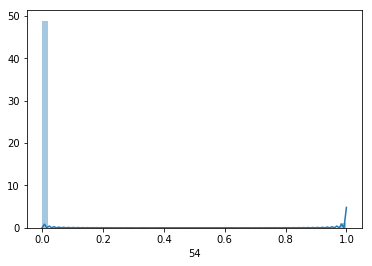

In [109]:
i=5
feature = X_train.iloc[:,i-1]
sns.distplot(feature)

### SVM

In [4]:
%%time
svm = SVC(C=1, gamma=1/345, probability=True, random_state=seed)
svm.fit(X_train, y_train)

Wall time: 16min 42s


In [5]:
pred = svm.predict(X_train)

In [6]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [7]:
pred_proba = svm.predict_proba(X_train)

In [11]:
pred_proba

array([[ 0.85482768,  0.14517232],
       [ 0.70518382,  0.29481618],
       [ 0.85457077,  0.14542923],
       ..., 
       [ 0.84775709,  0.15224291],
       [ 0.83965326,  0.16034674],
       [ 0.81759946,  0.18240054]])

In [12]:
print('roc_auc_train: ', roc_auc_score(y_train, svm.predict(X_train)))
print('roc_auc_val: ', roc_auc_score(y_val, svm.predict(X_val)))

roc_auc_train:  0.5
roc_auc_val:  0.5


In [13]:
print('roc_auc_train: ', roc_auc_score(y_train, svm.predict_proba(X_train)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, svm.predict_proba(X_val)[:,1]))

roc_auc_train:  0.838855684998
roc_auc_val:  0.679819895153


In [14]:
%%time
svm = SVC(C=10, gamma=1/345, probability=True, random_state=seed)
svm.fit(X_train, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, svm.predict_proba(X_train)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, svm.predict_proba(X_val)[:,1]))

roc_auc_train:  0.845822578867
roc_auc_val:  0.691043367593
Wall time: 20min 21s


In [15]:
%%time
svm = SVC(C=100, gamma=1/345, probability=True, random_state=seed)
svm.fit(X_train, y_train)
print('roc_auc_train: ', roc_auc_score(y_train, svm.predict_proba(X_train)[:,1]))
print('roc_auc_val: ', roc_auc_score(y_val, svm.predict_proba(X_val)[:,1]))

roc_auc_train:  0.845760381177
roc_auc_val:  0.691092069414
Wall time: 23min 2s
